## 第二部分：利用机器学习分析足球比赛（使用Squawka足球数据）
#### 作者：带球小弟

本文按照[第一部分：利用机器学习分析足球比赛（使用Kaggle欧洲足球数据库）](https://github.com/xzl524/football_data_analysis/blob/master/projects/match_outcome_prediction/match_outcome_retrodiction_kaggle_cn.ipynb)同样的步骤对职业足球比赛的数据进行分析，试图找到对比赛影响最大的因素。主要的不同点在于本文使用的是从Squawka足球数据网站上爬到的数据。这一数据源的数据量更大，比赛数据类型更多。

本文利用机器学习中的监督学习来回答以下问题：

* 足球比赛的数据统计可以在多大的程度上对应比赛结果？
* 哪种足球数据统计与比赛结果最为相关？

### 主要结论

* 主要模型结果总结如下：

|                   模型                               |   预测准确率（Squawka)   | 预测准确率（Kaggle）
| :--------------------------------------------------:| :------------:| :---:|
| 基准结果：随机猜测                                    |    33.4%      |    34.2%  |
| 基准结果：只猜主队赢                                  |    46.0%      |    46.0%  |
| 逻辑回归                                             |    62.6%      |    56.6%  |
| 线性判别分析                                         |    62.9%      |    56.6%  |
| 泊松回归                                             |    62.2%      |    56.0%  |
| 梯度提升                                             |    61.4%      |    56.4%  |
| 随机森林                                             |    61.6%      |    56.0%  |
| 神经网络                                             |    63.0%      |    56.2%  |
使用Squawka足球数据的模型预测准确率比使用Kaggle欧洲足球数据库要更高，达到了62~63%。这主要源于这一数据源中与比赛结果相关的比赛数据类型更多，同时更大的数据量降低了模型过拟合的风险。
* 影响比赛结果的数据排前三位的分别是：射门数，定位球和传中数，其中传中数为负相关。这意味着，传中越多，进球越少。

### 详细内容
#### 1. [数据预处理](#preprocess)
#### 2. [基准结果](#baseline)
#### 3. [模型选择](#model_selection)
#### 4. [模型评估](#model_evaluation)

In [2]:
%matplotlib inline
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

sns.set_style('white')
sns.set_context('poster')
sns.set_style({'font.sans-serif':['simhei','Arial']}) #图中显示中文

#### <a id='preprocess'></a>1. 数据预处理

#### 导入数据

In [3]:
# 导入包含比赛数据统计信息的比赛数据
data_dir = os.path.join(os.path.pardir, os.path.pardir, 'data_source', 'squawka', 'match_stats_squawka_footballdata.csv')
match = pd.read_csv(data_dir, encoding='utf-8', low_memory=False)

#### 数据预处理

In [4]:
match = match.rename(columns={'Date': 'date',
                              'HomeTeam': 'home_team',
                              'AwayTeam': 'away_team',
                              'FTHG': 'home_team_goal',
                              'FTAG': 'away_team_goal',
                              'HS': 'home_team_shot',
                              'AS': 'away_team_shot',
                              'HST': 'home_team_shoton',
                              'AST': 'away_team_shoton',
                              'HC': 'home_team_corner_footballdata',
                              'AC': 'away_team_corner_footballdata',
                              'HF': 'home_team_foul_footballdata',
                              'AF': 'away_team_foul_footballdata',
                              'HY': 'home_team_yellow_card',
                              'AY': 'away_team_yellow_card',
                              'HR': 'home_team_red_card',
                              'AR': 'away_team_red_card'})

# 合成净胜球数
goal_diff = match['home_team_goal'] - match['away_team_goal']

# 对比赛结果进行编码
# 主队获胜：0
# 双方打平：1
# 客队获胜：2
match['result'] = np.where(goal_diff > 0, 0, np.where(goal_diff < 0, 2, 1))

match.head()

,away_team_corner_footballdata,away_team_foul_footballdata,away_team_red_card,away_team_shot,away_team_shoton,away_team_yellow_card,away_team,B365A,B365D,B365H,...,away_team_corners,home_team_clearances,away_team_clearances,home_team_cards,away_team_cards,home_team_blocked_events,away_team_blocked_events,home_team_balls_out,away_team_balls_out,result
0,2.0,14.0,0.0,10.0,3.0,2.0,Werder Bremen,9.00,5.50,1.3,...,2.0,30.0,31.0,2.0,2.0,0.0,0.0,0.0,0.0,0
1,0.0,14.0,0.0,9.0,4.0,2.0,Fortuna Dusseldorf,3.60,3.50,2.0,...,0.0,5.0,29.0,3.0,2.0,0.0,0.0,0.0,0.0,2
2,7.0,22.0,0.0,19.0,10.0,2.0,Leverkusen,2.40,3.40,2.8,...,7.0,31.0,36.0,1.0,2.0,0.0,0.0,0.0,0.0,0
3,8.0,13.0,0.0,8.0,3.0,2.0,Mainz,2.75,3.30,2.5,...,8.0,38.0,45.0,0.0,2.0,0.0,0.0,0.0,0.0,1
4,4.0,13.0,0.0,19.0,9.0,2.0,Bayern Munich,1.36,4.75,8.5,...,4.0,20.0,13.0,2.0,2.0,0.0,0.0,0.0,0.0,2


#### 选择比赛相关信息

本文所使用的比赛相关信息包括：一对一次数、铲球数、定位球数、越位数、守门员解围数、断球数、头球争顶数、守门次数、射门数、犯规数、传中数、角球数、解围数、红黄牌数、阻挡次数、出界次数。另外，主客队的数据都会使用。

In [5]:
# 选择信息类型
events = ['takeons', 'tackles', 'setpieces', 'offside', 'keepersweeper', 'interceptions', 'headed_duals', 'goal_keeping',
          'goals_attempts', 'fouls', 'crosses', 'corners', 'clearances', 'cards', 'blocked_events', 'balls_out']
event_features = ['home_team_{}'.format(i) for i in events] + ['away_team_{}'.format(i) for i in events]

# 确认使用的信息
feature_list = event_features
print(feature_list)

['home_team_takeons', 'home_team_tackles', 'home_team_setpieces', 'home_team_offside', 'home_team_keepersweeper', 'home_team_interceptions', 'home_team_headed_duals', 'home_team_goal_keeping', 'home_team_goals_attempts', 'home_team_fouls', 'home_team_crosses', 'home_team_corners', 'home_team_clearances', 'home_team_cards', 'home_team_blocked_events', 'home_team_balls_out', 'away_team_takeons', 'away_team_tackles', 'away_team_setpieces', 'away_team_offside', 'away_team_keepersweeper', 'away_team_interceptions', 'away_team_headed_duals', 'away_team_goal_keeping', 'away_team_goals_attempts', 'away_team_fouls', 'away_team_crosses', 'away_team_corners', 'away_team_clearances', 'away_team_cards', 'away_team_blocked_events', 'away_team_balls_out']


#### 生成建模数据

In [6]:
# 移除缺失值
match_sel = match
for col in feature_list + ['result', 'home_team_goal', 'away_team_goal']:
    match_sel = match_sel[match_sel[col].notnull()]
    
# 训练集/测试集划分
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(match_sel, test_size=1000, random_state=42)

Xtrain = train_df[feature_list].values
Xtest = test_df[feature_list].values

y = match_sel['result'].values
ytrain = train_df['result'].values
ytest = test_df['result'].values

hgoaltrain = train_df['home_team_goal'].values
hgoaltest = test_df['home_team_goal'].values

agoaltrain = train_df['away_team_goal'].values
agoaltest = test_df['away_team_goal'].values

In [7]:
# 输入数据正则化
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

Xtrain_norm = mms.fit_transform(Xtrain)
Xtest_norm = mms.transform(Xtest)

In [8]:
print('总数据量：                          {}'.format(match_sel.shape[0]))
print('训练数据量（包括交叉验证数据）：      {}'.format(Xtrain_norm.shape[0]))
print('测试数据量：                        {}'.format(Xtest_norm.shape[0]))

总数据量：                          10734
训练数据量（包括交叉验证数据）：      9734
测试数据量：                        1000


#### <a id='baseline'></a>2. 基准结果

首先展示一些基准结果。基准结果可以看做是建模的底线，所有的模型结果需要超过基准结果才算有效。

#### 2.1 随机猜测

由理论计算可知，随机猜测的准确率为33.33%。

这是因为：假设胜/平/负三种结果出现的概率分别为$p_{w}$，$p_{d}$，和$p_{l}$，那么随机猜测时猜对胜这种结果的概率为$\frac{p_{w}}{3}$，猜对打平这种结果的概率为$\frac{p_{d}}{3}$，猜对负这种结果的概率为$\frac{p_{l}}{3}$。因此，随机猜测的准确率为：

$$\frac{p_w}{3}+\frac{p_d}{3}+\frac{p_l}{3}=\frac{p_w+p_d+p_l}{3}=\frac{1}{3}=33.3\% $$.

通过数据来验证一下：

In [10]:
# 随机猜测
np.random.seed(42)
y_pred = np.random.choice([0,1,2], len(y))
print('随机猜测')
print('预测准确率：{:.1f}%'.format(accuracy_score(y, y_pred)*100))

随机猜测
预测准确率：33.4%


这与理论计算结果非常接近。

#### 2.2 只猜主队赢

In [11]:
# 只猜平局
y_pred = np.zeros(len(y))
print('只猜平局')
print('预测准确率：{:.1f}%'.format(accuracy_score(y, y_pred)*100))

只猜平局
预测准确率：45.8%


#### 2.3 只猜平局

In [12]:
# 只猜平局
y_pred = np.ones(len(y))
print('只猜客队赢')
print('预测准确率：{:.1f}%'.format(accuracy_score(y, y_pred)*100))

只猜客队赢
预测准确率：24.9%


#### 2.4 只猜客队赢

In [13]:
# 只猜客队赢
y_pred = 2*np.ones(len(y))
print('只猜客队赢')
print('预测准确率：{:.1f}%'.format(accuracy_score(y, y_pred)*100))

只猜客队赢
预测准确率：29.3%


欧洲职业足球比赛胜平负的比率为： 46/25/29。更多细节请参见[这里](https://github.com/xzl524/football_data_analysis/blob/master/projects/european_soccer_database_analysis/02_goal_poisson_cn.ipynb)。

#### <a id='model_selection'></a>3. 模型选择

以下为监督学习建模的具体步骤。

模型选择这一步旨在确定各类模型中的超参数，实质为在同类模型中选择最优的模型配置。

逻辑回归、梯度提升和随机森林可以使用以下代码，利用交叉验证法和对数损失来确定模型的超参数。

#### 逻辑回归/梯度提升/随机森林

In [44]:
# 逻辑回归
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class='auto', solver='liblinear')
parameter_dic= {'C':[0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]}

# 梯度提升
#from sklearn.ensemble import GradientBoostingClassifier
#clf = GradientBoostingClassifier(max_depth=3, n_estimators=100)
#parameter_dic= {"n_estimators": range(140, 200, 10)}

# 随机森林
#from sklearn.ensemble import RandomForestClassifier
#clf = RandomForestClassifier(max_features=11, n_estimators=100)
#parameter_dic= {'n_estimators':range(100, 250, 10)}

In [45]:
# 使用交叉验证和对数损失来选择超参数
from sklearn.model_selection import validation_curve
cross_validation_fold = 5

train_scores, test_scores=validation_curve(estimator=clf,
                                           X=Xtrain_norm,
                                           y=ytrain,
                                           param_name=list(parameter_dic.keys())[0],
                                           param_range=parameter_dic.get(list(parameter_dic.keys())[0]),
                                           cv=cross_validation_fold, scoring='neg_log_loss')
train_mean=np.mean(train_scores, axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores, axis=1)
test_std=np.std(test_scores,axis=1)

最优的C为:               1000
负对数损失值（训练数据）：  -0.8133
负对数损失值(交叉验证数据)：-0.8206


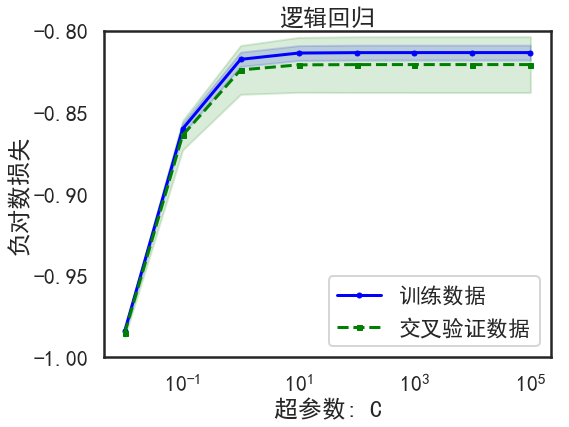

In [46]:
clf_dict = {'LogisticRegression': '逻辑回归',
            'GradientBoostingClassifier': '梯度提升',
            'RandomForestClassifier': '随机森林'
           }
plt.figure(figsize=(8,6))
plt.rcParams['mathtext.fontset'] = 'cm' # 数学负号使用机器默认字体
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),train_mean,
         color='blue',marker='o',
         markersize=5,label='训练数据')
plt.fill_between(parameter_dic.get(list(parameter_dic.keys())[0]),
                 train_mean+train_std,
                 train_mean-train_std,
                 alpha=0.15,color='blue')
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),test_mean,
         color='green',linestyle='--',
         marker='s',markersize=5,label='交叉验证数据')
plt.fill_between(parameter_dic.get(list(parameter_dic.keys())[0]),
                 test_mean+test_std,
                 test_mean-test_std,
                 alpha=0.15,color='green')
plt.xlabel('超参数: {}'.format(list(parameter_dic.keys())[0]))
plt.ylabel('负对数损失')
plt.legend(loc='lower right')
plt.title('{}'.format(clf_dict[clf.__class__.__name__]))
if clf.__class__.__name__ == 'LogisticRegression':
    plt.xscale('log')
plt.ylim(-1,-0.8)

print('最优的{}为:               {}'.format(list(parameter_dic.keys())[0], parameter_dic.get(list(parameter_dic.keys())[0])[np.argmax(test_mean)]))
print('负对数损失值（训练数据）：  {:.4f}'.format(train_mean[np.argmax(test_mean)]))
print('负对数损失值(交叉验证数据)：{:.4f}'.format(np.max(test_mean)))

#### 线性判别分析

线性判别分析没有超参数，但是同样可以使用交叉验证法检验模型是否过拟合。

平均对数损失（训练集）：    0.8220
平均对数损失（交叉验证集）：0.8276


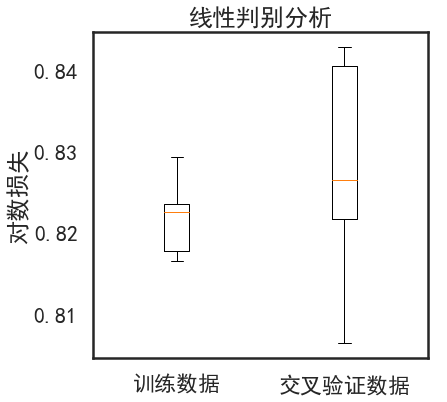

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()

cross_validation_fold = 5

train_scores = []
test_scores = []

kf = StratifiedKFold(n_splits=cross_validation_fold, shuffle=False)
    
for train, test in kf.split(Xtrain_norm, ytrain):
    
    clf.fit(Xtrain_norm[train], ytrain[train])
    train_scores.append(log_loss(ytrain[train], clf.predict_proba(Xtrain_norm[train])))
    test_scores.append(log_loss(ytrain[test], clf.predict_proba(Xtrain_norm[test])))

plt.figure(figsize=(6,6))
plt.boxplot([train_scores, test_scores], labels=['训练数据','交叉验证数据'])
plt.ylabel('对数损失')
plt.title('线性判别分析')
print('平均对数损失（训练集）：    {:.4f}'.format(np.mean(train_scores)))
print('平均对数损失（交叉验证集）：{:.4f}'.format(np.mean(test_scores)))

#### 泊松回归

利用泊松回归建模分两步：
1. 使用泊松回归模型，由比赛相关信息来估计主队和客队的进球数期望值；
2. 比较主客队的进球数期望值，利用泊松分布估计比赛胜平负出现的概率。

平均对数损失（训练集）：    0.8543
平均对数损失（交叉验证集）：0.8557


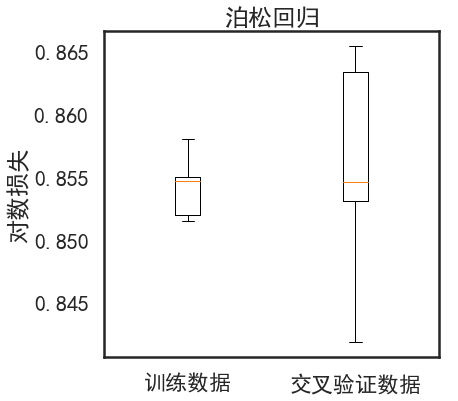

In [18]:
from footballmodels import PoissonRegression
clf = PoissonRegression()

cross_validation_fold = 5

train_scores = []
test_scores = []

kf = StratifiedKFold(n_splits=cross_validation_fold, shuffle=False)
    
for train, test in kf.split(Xtrain_norm, ytrain):
    
    clf.fit(Xtrain_norm[train], Xtrain_norm[train], hgoaltrain[train], agoaltrain[train])
    train_scores.append(log_loss(ytrain[train], clf.predict_proba(Xtrain_norm[train], Xtrain_norm[train])))
    test_scores.append(log_loss(ytrain[test], clf.predict_proba(Xtrain_norm[test], Xtrain_norm[test])))

plt.figure(figsize=(6,6))
plt.boxplot([train_scores, test_scores], labels=['训练数据','交叉验证数据'])
plt.title('泊松回归')
plt.ylabel('对数损失')
print('平均对数损失（训练集）：    {:.4f}'.format(np.mean(train_scores)))
print('平均对数损失（交叉验证集）：{:.4f}'.format(np.mean(test_scores)))

#### 神经网络

In [47]:
import tensorflow as tf
from tensorflow import keras

In [48]:
# 训练集/验证集划分
train_x, val_x, train_y, val_y = train_test_split(Xtrain_norm, ytrain, test_size=1000, stratify=ytrain, random_state=42)

In [60]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(Xtrain_norm.shape[1],), ),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.8),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.train.AdamOptimizer(),
                  metrics=['accuracy'])
    
    return model

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_x, train_y, epochs=100,
                    validation_data=(val_x, val_y), verbose=0)

当前模型训练集的准确率为62.01%
当前模型训练集的对数损失为0.840
当前模型验证集的准确率60.40%
当前模型验证集的对数损失为0.838


(0.8, 1)

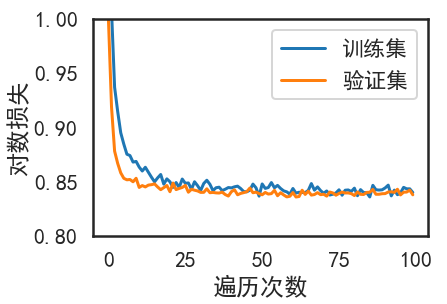

In [64]:
def plot_history(history, kind='acc'):
    plt.figure()
    plt.xlabel('遍历次数')
    if kind == 'acc':
        plt.ylabel('准确率')
        plt.plot(history.epoch, np.array(history.history['acc']),
                 label='训练集')
        plt.plot(history.epoch, np.array(history.history['val_acc']),
                 label = '验证集')
        plt.legend()
    elif kind == 'loss':
        plt.ylabel('对数损失')
        plt.plot(history.epoch, np.array(history.history['loss']),
                 label='训练集')
        plt.plot(history.epoch, np.array(history.history['val_loss']),
                 label = '验证集')
        plt.legend()


print('当前模型训练集的准确率为{:.2f}%'.format(history.history['acc'][-1]*100))
print('当前模型训练集的对数损失为{:.3f}'.format(history.history['loss'][-1]))

print('当前模型验证集的准确率{:.2f}%'.format(history.history['val_acc'][-1]*100))
print('当前模型验证集的对数损失为{:.3f}'.format(history.history['val_loss'][-1]))

plot_history(history, kind='loss')
plt.ylim(0.8, 1)

#### <a id='model_evaluation'></a>4. 模型评估

下面利用测试集的数据对模型进行评估。

#### 4.1 逻辑回归

In [19]:
from sklearn.linear_model import LogisticRegression
best_clf = LogisticRegression(C=1000, multi_class='auto', solver='liblinear')

# 拟合训练数据
best_clf.fit(Xtrain_norm, ytrain)

# 输出比赛结果概率估计
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### 模型评估
print('模型：     逻辑回归')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

模型：     逻辑回归
对数损失：  0.8273
预测准确率：62.6%


#### 4.2 线性判别分析

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
best_clf = LinearDiscriminantAnalysis()

# 拟合训练数据
best_clf.fit(Xtrain_norm, ytrain)

# 输出比赛结果概率估计
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### 模型评估
print('模型：     线性判别分析')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

模型：     线性判别分析
对数损失：  0.8331
预测准确率：62.9%


#### 4.3 泊松回归

In [21]:
from footballmodels import PoissonRegression
best_clf = PoissonRegression()

# 拟合训练数据
best_clf.fit(Xtrain_norm, Xtrain_norm, hgoaltrain, agoaltrain)

# 输出比赛结果概率估计
ytest_prob = best_clf.predict_proba(Xtest_norm, Xtest_norm)

#### 模型评估
print('模型：     泊松回归')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

模型：     泊松回归
对数损失：  0.8601
预测准确率：62.2%


#### 泊松回归中信息关联性分析

In [22]:
feature_dic = {'home_team_takeons': '主队一对一次数',
               'home_team_tackles': '主队铲球数',
               'home_team_setpieces': '主队定位球数',
               'home_team_offside': '主队越位次数',
               'home_team_keepersweeper': '主队守门员解围数',
               'home_team_interceptions': '主队断球数',
               'home_team_headed_duals': '主队头球争顶数',
               'home_team_goal_keeping': '主队守门员守门次数',
               'home_team_goals_attempts': '主队射门数',
               'home_team_fouls': '主队犯规数',
               'home_team_crosses': '主队传中数',
               'home_team_corners': '主队角球数',
               'home_team_clearances': '主队解围数',
               'home_team_cards': '主队红黄牌数',
               'home_team_blocked_events': '主队阻挡次数',
               'home_team_balls_out': '主队出界次数',
               'away_team_takeons': '客队一对一次数',
               'away_team_tackles': '客队铲球数',
               'away_team_setpieces': '客队定位球数',
               'away_team_offside': '客队越位次数',
               'away_team_keepersweeper': '客队守门员解围数',
               'away_team_interceptions': '客队断球数',
               'away_team_headed_duals': '客队头球争顶数',
               'away_team_goal_keeping': '客队守门员守门次数',
               'away_team_goals_attempts': '客队射门数',
               'away_team_fouls': '客队犯规数',
               'away_team_crosses': '客队传中数',
               'away_team_corners': '客队角球数',
               'away_team_clearances': '客队解围数',
               'away_team_cards': '客队红黄牌数',
               'away_team_blocked_events': '客队阻挡次数',
               'away_team_balls_out': '客队出界次数'}

# 显示中文特征值
feature_list_cn = [feature_dic[key] for key in feature_list]

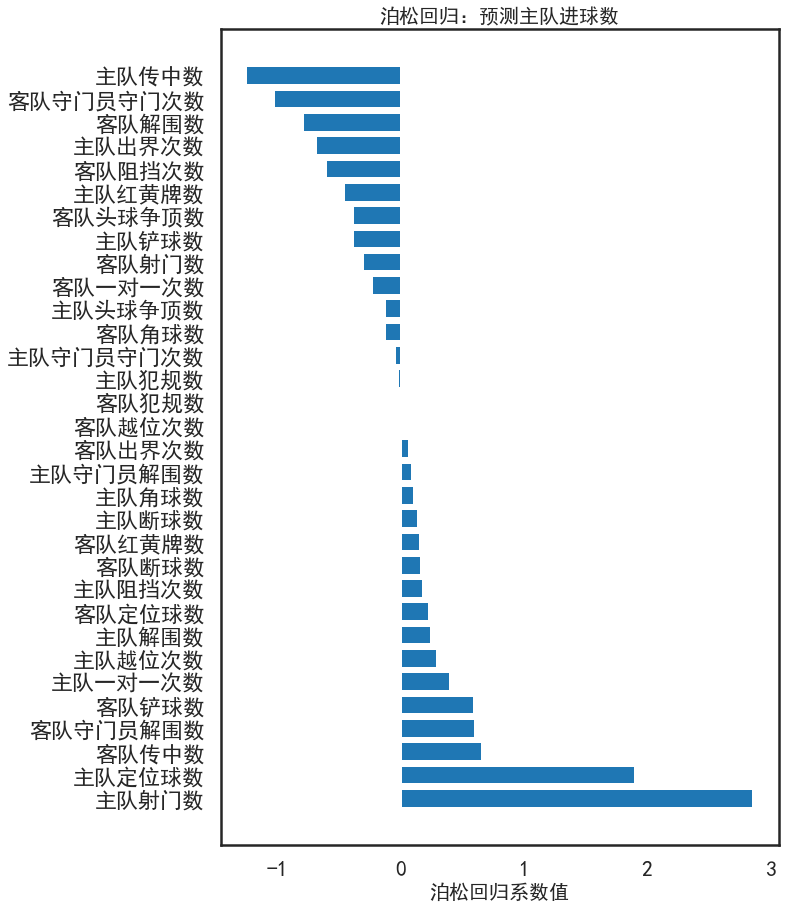

In [23]:
encoded_home_feature_list = feature_list_cn
importance_list, name_list = zip(*sorted(zip(best_clf.hgoal_reg.params, encoded_home_feature_list),reverse=True))

plt.figure(figsize=(10,15))
plt.barh(range(len(name_list)), importance_list,align='center')
plt.yticks(range(len(name_list)), name_list)
plt.xlabel('泊松回归系数值', fontsize=20)
plt.title('泊松回归：预测主队进球数', fontsize=20)
#plt.xlim(-1,1)
plt.show()

可以看到，与主队进球数最相关的是主队射门数，射门越多，进球越多。其次是主队定位球数。排在第三的是传中数，但是注意，两者的关系是负的，传中越多，进球越少。

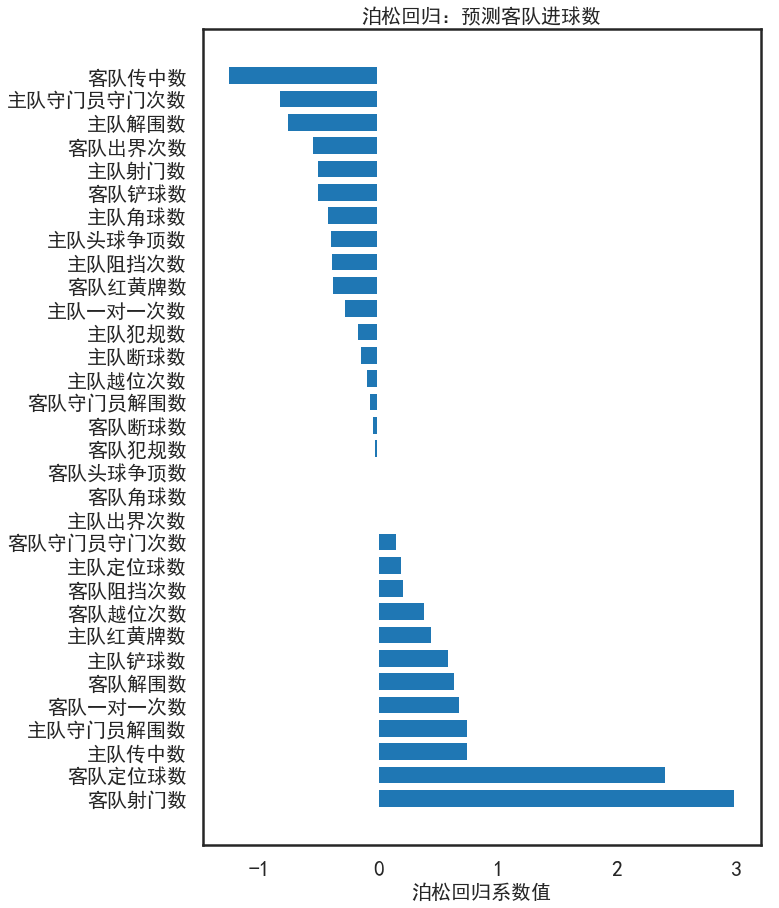

In [41]:
encoded_away_feature_list = feature_list_cn
importance_list, name_list = zip(*sorted(zip(best_clf.agoal_reg.params, encoded_away_feature_list),reverse=True))

plt.figure(figsize=(10,15))
plt.barh(range(len(name_list)), importance_list,align='center')
plt.yticks(range(len(name_list)), name_list, fontsize=20)
plt.xlabel('泊松回归系数值', fontsize=20)
plt.title('泊松回归：预测客队进球数', fontsize=20)
#plt.xlim(-1,1)
plt.show()

另一方面，与客队进球数最相关的数据是客队射门数，射门越多，进球越多。其次是客队定位球数，第三是传中数，传中数越多，进球越少。

#### 4.4 梯度提升

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
best_clf = GradientBoostingClassifier(max_depth=3, n_estimators=140)

# 拟合训练数据
best_clf.fit(Xtrain_norm, ytrain)

# 输出比赛结果概率估计
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### 模型评估
print('模型：      梯度提升'.format(best_clf.__class__.__name__))
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

模型：      梯度提升
对数损失：  0.8292
预测准确率：61.4%


#### 特征重要性分析

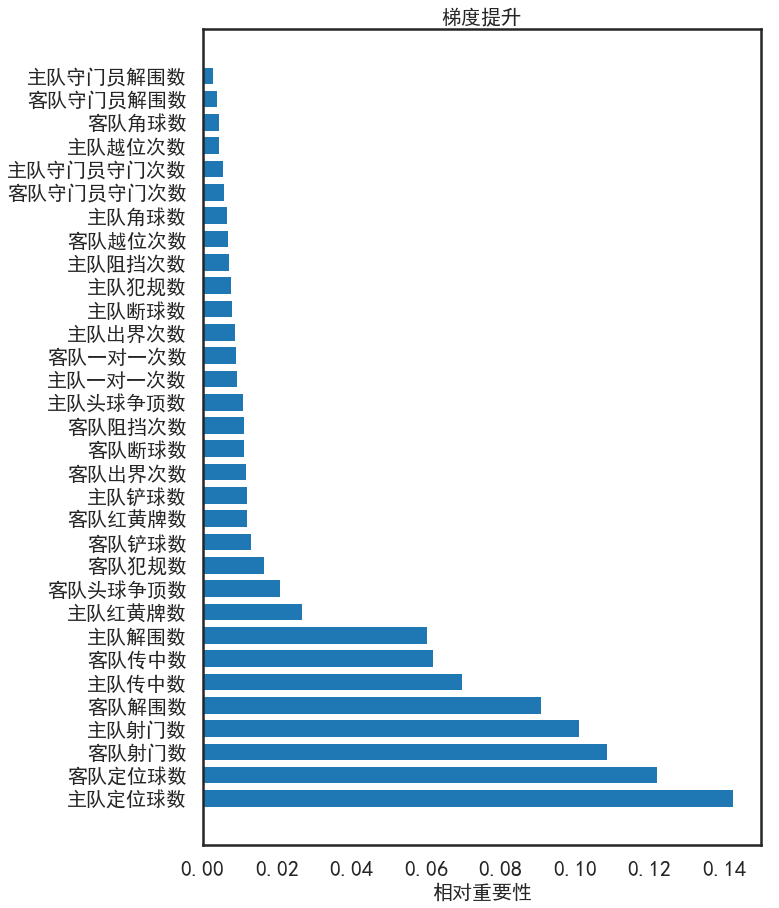

In [44]:
importance_list = best_clf.feature_importances_
importance_list, name_list = zip(*sorted(zip(importance_list, feature_list_cn),reverse=True))
plt.figure(figsize=(10,15))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list, fontsize=20)
plt.xlabel('相对重要性', fontsize=20)
plt.title('梯度提升', fontsize=20)
plt.show()

#### 4.5 随机森林

In [43]:
from sklearn.ensemble import RandomForestClassifier
best_clf = RandomForestClassifier(max_features=11, n_estimators=230)

# 拟合训练数据
best_clf.fit(Xtrain_norm, ytrain)

# 输出比赛结果概率估计
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### 模型评估
print('模型：随机森林')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

模型：随机森林
对数损失：  0.8542
预测准确率：61.6%


#### 特征重要性分析

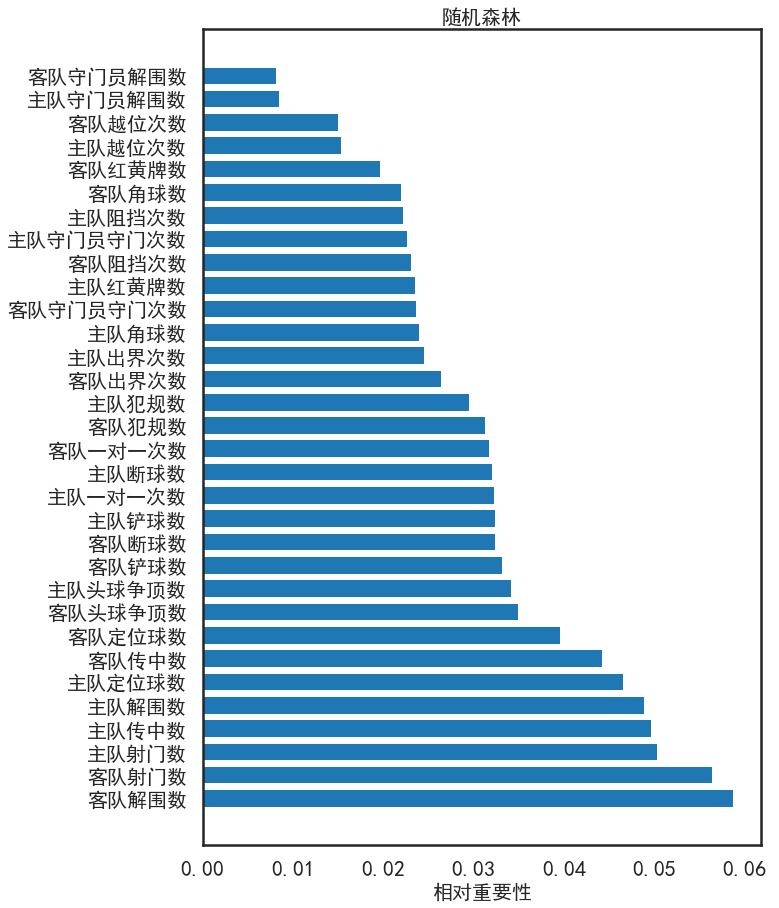

In [47]:
importance_list = best_clf.feature_importances_
importance_list, name_list = zip(*sorted(zip(importance_list, feature_list_cn),reverse=True))
plt.figure(figsize=(10,15))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list, fontsize=20)
plt.xlabel('相对重要性', fontsize=20)
plt.title('随机森林', fontsize=20)
plt.show()

#### 4.6 神经网络

In [65]:
# 拟合训练数据
model.fit(Xtrain_norm, ytrain, epochs=100, verbose=0)

# 输出比赛结果概率估计
ytest_prob = model.predict_proba(Xtest_norm)

#### 模型评估
print('模型：      神经网络')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

模型：      神经网络
对数损失：  0.8103
预测准确率：63.00%
